In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from matplotlib.dates import date2num
import numpy as np
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo
import os
from collections import OrderedDict
from matplotlib.path import Path


In [8]:
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['land'])
pc = cartopy.crs.PlateCarree()
merc = cartopy.crs.Mercator(central_longitude=-85.0)

plots = {'Water Level [m]': {'color': 'r', 'marker': 'o', 'ms': 10, 'alpha': 0.5}, 
         'WaterT [deg C]': {'color': 'b', 'marker': '.', 'ms': 10, 'alpha': 0.5}, 
         'Depth [m]': {'color': 'r', 'marker': 'o', 'ms': 10, 'alpha': 0.5},  
         'East [m/s]': {'color': 'g', 'marker': '>', 'ms': 10, 'alpha': 0.25}, 
         'North [m/s]': {'color': 'g', 'marker': '>', 'ms': 10, 'alpha': 0.25}, 
         'Salinity': {'color': 'k', 'marker': '*', 'ms': 10, 'alpha': 0.5}, 
         'Along [cm/s]': {'color': 'darkcyan', 'marker': '^', 'ms': 10, 'alpha': 0.5},
         'Across [cm/s]': {'color': 'darkcyan', 'marker': '^', 'ms': 10, 'alpha': 0.5}}


In [3]:
## read in bathymetry ##

# create arrays of lon/lat
num = 10261
dd = 9.2592589999999e-005
xllcorner = -95.250046296295
yllcorner = 28.849953716305
x = np.linspace(xllcorner, xllcorner+dd*num, num)
y = np.linspace(yllcorner, yllcorner+dd*num, num)
lon, lat = np.meshgrid(x, y)

# use every fifth bathymetry point
# bathymetry was decimated on hafen and scp'ed to here
bathy = np.load('Galveston_DEM_1072/bathy_every_fifth.npz')['bathy'][::-1,:]
np.savetxt('bathy_every_fifth.txt', bathy)
lon = lon[::5, ::5]
lat = lat[::5, ::5]



In [4]:
# use previously-clicked points along coast to separate bathymetry outside galveston bay
d = np.load('../shelf_transport/calcs/coastpts.npz')

# remove lat/lon away from g bay
inds = (d['lon']>lon.min()) * (d['lon']<lon.max())
# lonpts[inds] = np.nan; latpts[inds] = np.nan
lonpts = d['lon'][inds]; latpts = d['lat'][inds]

# make path around galveston bay
lonpts = np.hstack((lonpts, lon.max(), lon.min(), lon.min()))
latpts = np.hstack((latpts, 29.8, 29.8, latpts.min()))
pts = np.vstack((lonpts, latpts)).T
path = Path(pts)

In [5]:
inds = ~path.contains_points(np.vstack((lon.flatten(), lat.flatten())).T).reshape(lon.shape)
# inds.shape
bathy[inds] = np.nan

/Users/kthyng/miniconda3/envs/cart/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


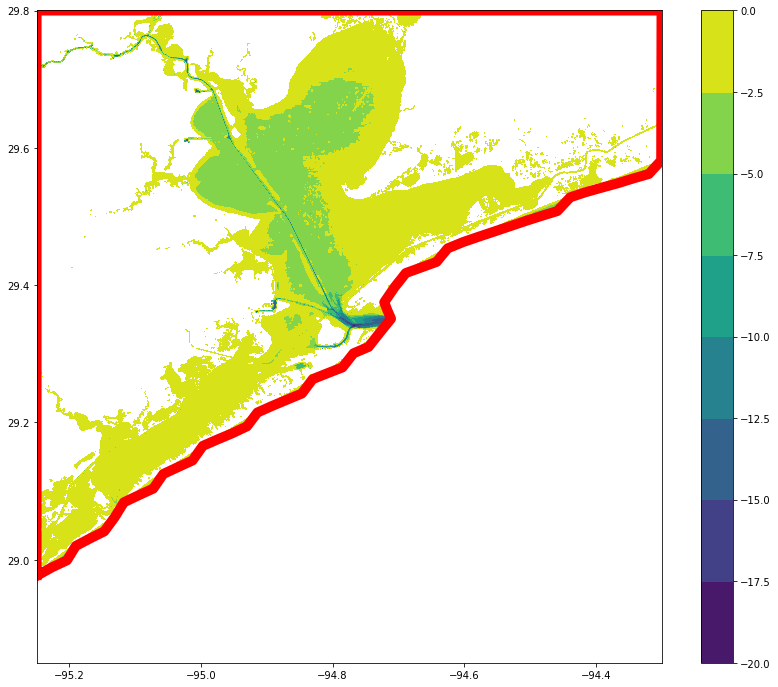

In [6]:
inds = bathy>0
bathy[inds] = np.nan
np.savez('Galveston_DEM_1072/bathy_galv.npz', bathy=bathy, lon=lon, lat=lat)

# coast
fig, ax = plt.subplots(figsize=(14,12))
mappable = ax.contourf(lon, lat, bathy); 
fig.colorbar(mappable)
ax.plot(path.vertices[:,0], path.vertices[:,1], 'r', lw=10)
# plt.xlim(lon.min(), lon.max())
# plt.ylim(lat.min(), lat.max())

In [9]:
laea = cartopy.crs.LambertAzimuthalEqualArea()
pts = laea.transform_points(pc, lon, lat)
xp = pts[:,:,0]; yp  = pts[:,:,1]
dx = np.diff(xp[0,:]).mean()
dy = np.diff(yp[:,0]).mean()

# # grid in projected space
# X, Y = np.meshgrid(np.linspace(xp.min(), xp.max(), 100), np.linspace(yp.min(), yp.max(), 110))

# surface area of Galveston Bay (assume there aren't significant new tidal plains from flooding)
# also assuming that this data is just in Galveston Bay and not too far onto the shelf...
# is True where is water
# water = bathy<0

np.nansum(~np.isnan(bathy)*dx*dy)/(1000**2)

1269.7529202644398

In [16]:
# CALCULATE THE BATHY OF WEST AND EAST BAYS SEPARATELY TO INCLUDE IN CALCULATION
# remove side bays
bathy = np.load('Galveston_DEM_1072/bathy_galv.npz')['bathy']
# west bay
inds = ((lat<29.4) * (lon<-94.9)) | ((lat<29.37) * (lon<-94.87)) | ((lat<29.365) * (lon<-94.825))
bathyw = bathy.copy()
bathy[inds] = np.nan  # for main bay
bathyw[~inds] = np.nan  # for west bay
np.savez('Galveston_DEM_1072/bathy_galv_west.npz', bathy=bathyw, lon=lon, lat=lat, dx=dx, dy=dy)
# east bay
inds = ((lat<29.55) * (lon>-94.75) * (lat>29.37)) | ((lat<29.8) * (lon>-94.69)) #| ((lat<29.365) * (lon<-94.825))
bathye = bathy.copy()
bathy[inds] = np.nan
bathye[~inds] = np.nan
np.savez('Galveston_DEM_1072/bathy_galv_east.npz', bathy=bathye, lon=lon, lat=lat, dx=dx, dy=dy)
np.savez('Galveston_DEM_1072/bathy_galv_main.npz', bathy=bathy, lon=lon, lat=lat, dx=dx, dy=dy)


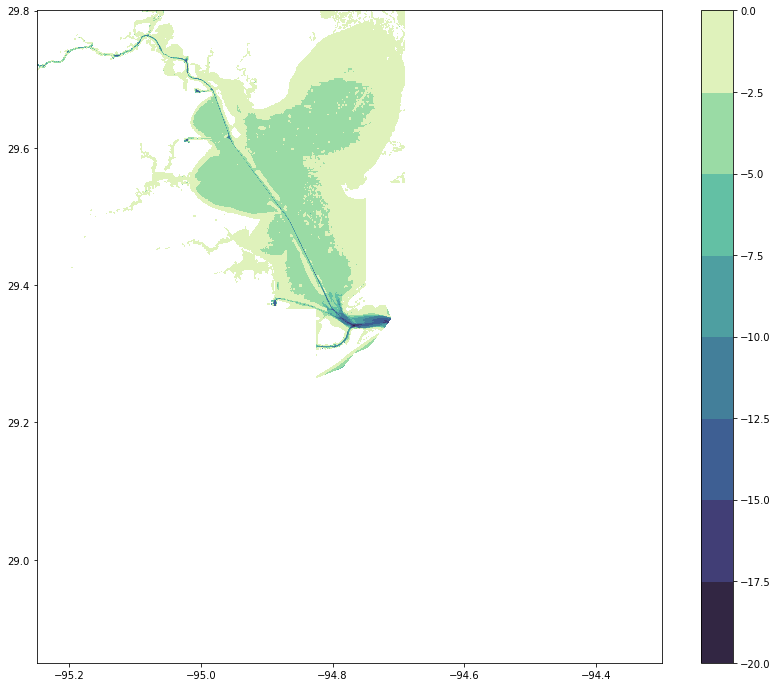

In [13]:
fig, ax = plt.subplots(figsize=(14,12))
mappable = ax.contourf(lon, lat, bathy, cmap=cmo.deep_r); 
fig.colorbar(mappable)

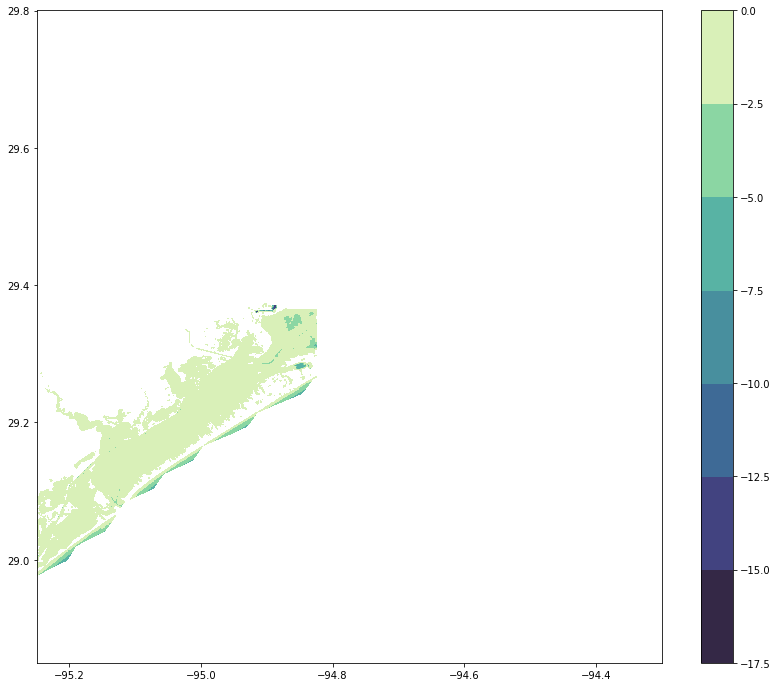

In [12]:
fig, ax = plt.subplots(figsize=(14,12))
mappable = ax.contourf(lon, lat, bathyw, cmap=cmo.deep_r); 
fig.colorbar(mappable)

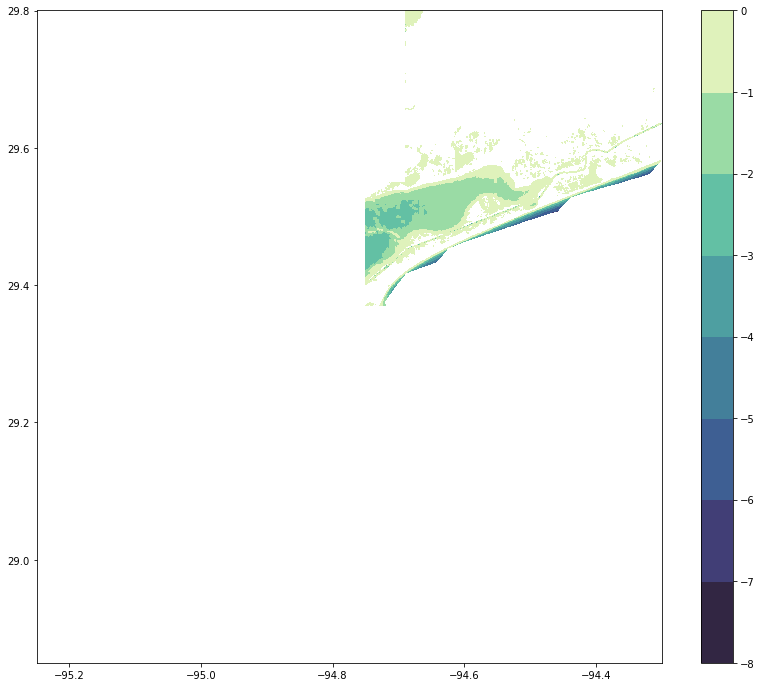

In [14]:
fig, ax = plt.subplots(figsize=(14,12))
mappable = ax.contourf(lon, lat, bathye, cmap=cmo.deep_r); 
fig.colorbar(mappable)
